# Investigation aof soccer game results

Analysis of 25979 soccer games in 11 European leagues between the seasons 2008/2009 and 2015/2016. Four tables are nedded  from the European soccer database. These are leque, country, match, and team. <br>
The analysis consists of three major parts. <br>
- imvestigation of game results: most likely results, relation between home--team victory and away-team victory, number of goals
- ivestigation of home-team advantage for each legue and season including statistical evaluation with t-tesst
- performance of Hamburger SV in comparison to FC Bayern Munich: points and goals 

Datasets: database.sqlite.zip
    

In [1]:
# loading packages and modules
import os, sys
from zipfile import ZipFile
import numpy as np
import pandas as pd
import datetime as dt
import time
import scipy.stats as st
import statsmodels.api as sm
# statsmodels.api uses factor analysis from scipy -> a downgrade to scipy-1.2 is needed

import sqlite3
from string import ascii_letters

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline

F:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Load data

In [2]:
# soccer FIFA soccer database
t1 = time.time()

# unzip database
zip_path = 'Z://IT-Projekte/FIFA soccer analysis/database.sqlite.zip'
zip_file = ZipFile(zip_path)
zip_file.extractall()

data_path = zip_file.filename[:-4]
#data_path = 'Z://IT-Projekte/FIFA soccer analysis/database.sqlite'

# tables from the SQL database
df = sqlite3.connect(data_path)
country = pd.read_sql_query("SELECT * FROM country",df)
league = pd.read_sql_query("SELECT * FROM league",df)
match = pd.read_sql_query("SELECT * FROM match",df)
player = pd.read_sql_query("SELECT * FROM player",df)
player_attributes = pd.read_sql_query("SELECT * FROM player_attributes",df)
team = pd.read_sql_query("SELECT * FROM team",df)
team_attributes = pd.read_sql_query("SELECT * FROM team_attributes",df)
sqlite_sequence =  pd.read_sql_query("SELECT * FROM sqlite_sequence",df)
df.close()

t2 = time.time()
print("loading data needed {:5.2f} seconds".format(t2-t1))

loading data needed 30.09 seconds


## Functions and Settings

In [3]:
# funtion to perform t-Test
def ttest(x1, x2, alpha):
    t, p, df_ = sm.stats.ttest_ind(x1, x2)

    # correlation coefficient to datermine the effect size (0.1 = weak, m0.3 = iddle, 0.5 = strong after Cohen (1992))
    r = abs(np.sqrt((t**2)/(t**2+df_)))

    print('='*60)
    print('t-Test')
    print('-'*60)
    print('t = {:0.3f}\tp = {:0.3f}\tdf = {:0.3f}\tr = {:0.3f}'.format(t, p, df_,r))
    # interpret
    print('-'*60)
    alpha = alpha
    if p > alpha:
        print('Same distribution (fail to reject H0 -> H0 is accepted)')
    else:
        print('Different distribution (reject H0 -> H1 is accepted)')
    print('='*60)

In [4]:
# Setting of important displaying options

#Pandas - Show more rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#Seaborn
sns.set_style("darkgrid")
plt.matplotlib.style.use('default')

#Create customised palette
my_colors = ["windows blue", "saffron", "hot pink", "algae green", "dusty purple", 
             "greyish", "petrol", "denim blue", "lime", "dark cyan", "indigo", "khaki",
             "navy", "red violet" , "shamrock", "stone", "stormy blue", "wintergreen", "wisteria",
             "heather", "liliac"]

sns.set_palette(sns.xkcd_palette(my_colors))
colors = sns.xkcd_palette(my_colors)

# Data Exploration

In [5]:
# reduce match to used columns
match2 = match.iloc[:,:11].copy()

In [6]:
# listed names of used tables
tables = {'league':league, 'country':country, 'match':match2, 'team':team}

# ooutput of table attributes, attribute types, and number of missing values
for table in tables:
    print(100*'*')
    print(table)
    print(len(table)*'=')
    print('this table consists of {:} rows and {:} columns: '.format(tables[table].shape[0],tables[table].shape[1]))
    for c in tables[table].columns:
        print("{:30} {:6.0f} {:6.0f} {:6.3f} {:6.0f} {:}".format(
            c, len(tables[table][c]), tables[table][c].isnull().sum(), 
            tables[table][c].isnull().sum()/len(tables[table]), 
            tables[table][c].nunique(), tables[table][c].dtype))

****************************************************************************************************
league
this table consists of 11 rows and 3 columns: 
id                                 11      0  0.000     11 int64
country_id                         11      0  0.000     11 int64
name                               11      0  0.000     11 object
****************************************************************************************************
country
this table consists of 11 rows and 2 columns: 
id                                 11      0  0.000     11 int64
name                               11      0  0.000     11 object
****************************************************************************************************
match
=====
this table consists of 25979 rows and 11 columns: 
id                              25979      0  0.000  25979 int64
country_id                      25979      0  0.000     11 int64
league_id                       25979      0  0.000     11 int64
sea

no missing values in the context of our study. All games are listed with humber of goals and names of the teams.Game descriptions and player information ist not needed.

In [7]:
# the range of data including minimum, maximum, mean, median, and standard deviation of all numeric attributes
for table in tables:
    print(100*'*')
    print(table)
    print(len(table)*'=')
# headlines
    fmt = "{:30} {:>6}" + 5*" {:>8}"
    print(fmt.format('','SIZE','MIN','MAX','MEDIAN','MEAN','STDEV'))
    for c in tables[table].select_dtypes(exclude='object').columns:
# only max and min for index attributes
        if (c=='id') or ('api_id' in c) or ('_id' in c):
            fmt = "{:30} {:6.0f}" + 2*" {:8.0f}"
            print(fmt.format(
                c, len(tables[table][c]), 
                tables[table][c].min(), tables[table][c].max() 
            ))
# with mean, median, and std for the other numeric columns
        else:
            fmt = "{:30} {:6.0f}" + 5*" {:8.2f}"
            print(fmt.format(
                c, len(tables[table][c]), 
                tables[table][c].min(), tables[table][c].max(), tables[table][c].median(),
                tables[table][c].mean(), tables[table][c].std() 
            ))


****************************************************************************************************
league
                                 SIZE      MIN      MAX   MEDIAN     MEAN    STDEV
id                                 11        1    24558
country_id                         11        1    24558
****************************************************************************************************
country
                                 SIZE      MIN      MAX   MEDIAN     MEAN    STDEV
id                                 11        1    24558
****************************************************************************************************
match
=====
                                 SIZE      MIN      MAX   MEDIAN     MEAN    STDEV
id                              25979        1    25979
country_id                      25979        1    24558
league_id                       25979        1    24558
stage                           25979     1.00    38.00    18.00    18.24    10.41
ma

In [8]:
team.head(5)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [9]:
match2.sample(20).sort_values(by='id')

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
1069,1070,1,1,2012/2013,18,2012-12-01 00:00:00,1224120,8635,9984,2,1
4419,4420,1729,1729,2015/2016,12,2015-11-08 00:00:00,1988821,10252,8456,0,0
6642,6643,4769,4769,2012/2013,7,2012-09-29 00:00:00,1216875,9831,7794,2,2
7805,7806,4769,4769,2015/2016,9,2015-10-04 00:00:00,1989866,9847,8592,2,1
8876,8877,7809,7809,2011/2012,24,2012-03-03 00:00:00,1030294,8350,8721,0,0
10297,10298,10257,10257,2008/2009,13,2008-11-23 00:00:00,539676,9882,8530,3,0
10575,10576,10257,10257,2008/2009,38,2009-05-31 00:00:00,539938,8686,9804,3,2
11461,11462,10257,10257,2011/2012,15,2011-12-11 00:00:00,1083243,6269,9875,1,1
11926,11927,10257,10257,2012/2013,25,2013-02-17 00:00:00,1287209,9878,8529,0,2
13075,13076,10257,10257,2015/2016,26,2016-02-21 00:00:00,2060396,7943,8534,3,2


In [10]:
# seasons in the dataset
match2.season.unique()

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

In [11]:
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [12]:
# number of stages per season and league
pd.pivot_table(match2, index=["league_id"], values=["stage"],
               columns=["season"], aggfunc=[pd.Series.nunique], fill_value=0).astype('int')

nunique                                                    \
              stage                                                     
season    2008/2009 2009/2010 2010/2011 2011/2012 2012/2013 2013/2014   
league_id                                                               
1                34        30        30        30        30         6   
1729             38        38        38        38        38        38   
4769             38        38        38        38        38        38   
7809             34        34        34        34        34        34   
10257            38        38        38        38        38        38   
13274            34        34        34        34        34        34   
15722            30        30        30        30        30        30   
17642            30        30        30        30        30        30   
19694            38        38        38        38        38        38   
21518            38        38        38        38        38        38   
24558            36        36        36        36        36        36   

                               
                               
season    2014/2015 2015/2016  
league_id                      
1                30        30  
1729             38        38  
4769             38        38  
7809             34        34  
10257            38        38  
13274            34        34  
15722            30        30  
17642            34        34  
19694            38        38  
21518            38        38  
24558            36        36

The Belgian Jupiler League misses some stages in the dataset. Thus it is not entirely complete. The Portugal Liga ZON Sagres experiences in increase in stages in season 2014/15 from 30 to 34. The league was extended by 2 from 16 to 18 teams (see www.transfermakt.de). 

## Data preprocessing

In [13]:
# long_name and api_id are needed from the team table
team2 = team[['team_api_id','team_long_name']]

# the first 11 columns from match are needed
match2 = match.iloc[:,0:11].copy()

# league and country merged to table match
match2 = match2.merge(team2, left_on='home_team_api_id', right_on='team_api_id')
match2 = match2.merge(team2, left_on='away_team_api_id', right_on='team_api_id', suffixes=('_h','_a'))

# names of away-team and home-team are merged to table match
match2 = match2.merge(league, left_on='league_id', right_on='id',suffixes=('','_r'), how='inner')
match2.drop(columns = ['league_id','id_r','country_id_r'],inplace=True)
match2.rename(columns = {'name':'league'},inplace=True)

match2 = match2.merge(country, left_on='country_id', right_on='id',suffixes=('','_r'), how='inner')
match2.drop(columns = ['country_id','id_r'],inplace=True)
match2.rename(columns = {'name':'country'},inplace=True)

match2.sort_values(by='id',inplace=True)

# total number of goals
match2['total_goals'] = match2.home_team_goal + match2.away_team_goal

# number of points woh by home- and away-teams in each match
match2['home_team_point'] = match2.apply(lambda x: 3 if x['home_team_goal'] > x['away_team_goal'] 
                                            else ( 1 if x['home_team_goal'] == x['away_team_goal']  else 0), axis=1)
match2['away_team_point'] = match2.apply(lambda x: 3 if x['home_team_goal'] < x['away_team_goal'] 
                                            else ( 1 if x['home_team_goal'] == x['away_team_goal']  else 0), axis=1)

In [14]:
# output of a sample of 20 datasets but wtthout the ids
dropid = ['id','home_team_api_id','away_team_api_id','team_api_id_a','team_api_id_h', 'match_api_id']
match2.drop(columns=dropid).sample(5).sort_values(by='country')

,season,stage,date,home_team_goal,away_team_goal,team_long_name_h,team_long_name_a,league,country,total_goals,home_team_point,away_team_point
703,2015/2016,7,2015-09-12 00:00:00,1,1,SV Zulte-Waregem,KAA Gent,Belgium Jupiler League,Belgium,2,1,1
2208,2015/2016,9,2015-10-19 00:00:00,0,1,Swansea City,Stoke City,England Premier League,England,1,0,3
5781,2015/2016,4,2015-08-29 00:00:00,4,1,Stade de Reims,FC Lorient,France Ligue 1,France,5,3,0
9017,2011/2012,25,2012-03-10 00:00:00,3,2,VfL Wolfsburg,Bayer 04 Leverkusen,Germany 1. Bundesliga,Germany,5,3,0
22688,2015/2016,23,2016-02-05 00:00:00,3,0,Málaga CF,Getafe CF,Spain LIGA BBVA,Spain,3,3,0


# Analysis of game results and goals

Hier werden die Spielergebnisse für jede Liga über die für die Saisonen 2008/2009 - 2015/2016 analysiert. Es wird der Frage nachgegangen wie häufig bestimmte Spielergebnisse sind und wann die meisten Tore gefallen sind. Darüber hinaus wird der höchste Heimsieg sowie der höchste Auswärtssieg in jeder Liga ermittelt.

## Number of goals in each league

In [15]:
# average number of goals per game
mean_goals = match2.groupby(by=['league','season']).total_goals.mean().reindex()

en = match2[match2.country == 'England'].groupby(by=['season']).mean()
fr = match2[match2.country == 'France'].groupby(by=['season']).mean()
ge = match2[match2.country == 'Germany'].groupby(by=['season']).mean()
it = match2[match2.country == 'Italy'].groupby(by=['season']).mean()
sp  = match2[match2.country == 'Spain'].groupby(by=['season']).mean()
po = match2[match2.country == 'Portugal'].groupby(by=['season']).mean()
sc = match2[match2.country == 'Scotland'].groupby(by=['season']).mean()
sw = match2[match2.country == 'Switzerland'].groupby(by=['season']).mean()
nl = match2[match2.country == 'Netherlands'].groupby(by=['season']).mean()

# total number of goals in each seasion
total_goals = match2.groupby(by=['league','season']).total_goals.sum().reindex()

en2 = match2[match2.country == 'England'].groupby(by=['season']).sum()
fr2 = match2[match2.country == 'France'].groupby(by=['season']).sum()
ge2 = match2[match2.country == 'Germany'].groupby(by=['season']).sum()
it2 = match2[match2.country == 'Italy'].groupby(by=['season']).sum()
sp2  = match2[match2.country == 'Spain'].groupby(by=['season']).sum()
po2 = match2[match2.country == 'Portugal'].groupby(by=['season']).sum()
sc2 = match2[match2.country == 'Scotland'].groupby(by=['season']).sum()
sw2 = match2[match2.country == 'Switzerland'].groupby(by=['season']).sum()
nl2 = match2[match2.country == 'Netherlands'].groupby(by=['season']).sum()

# x-labels and legend labels
seasons = match2.season.unique()
leagues = match2.league.unique()
countries = match2.country.unique()

In [21]:
plt.style.use('ggplot')

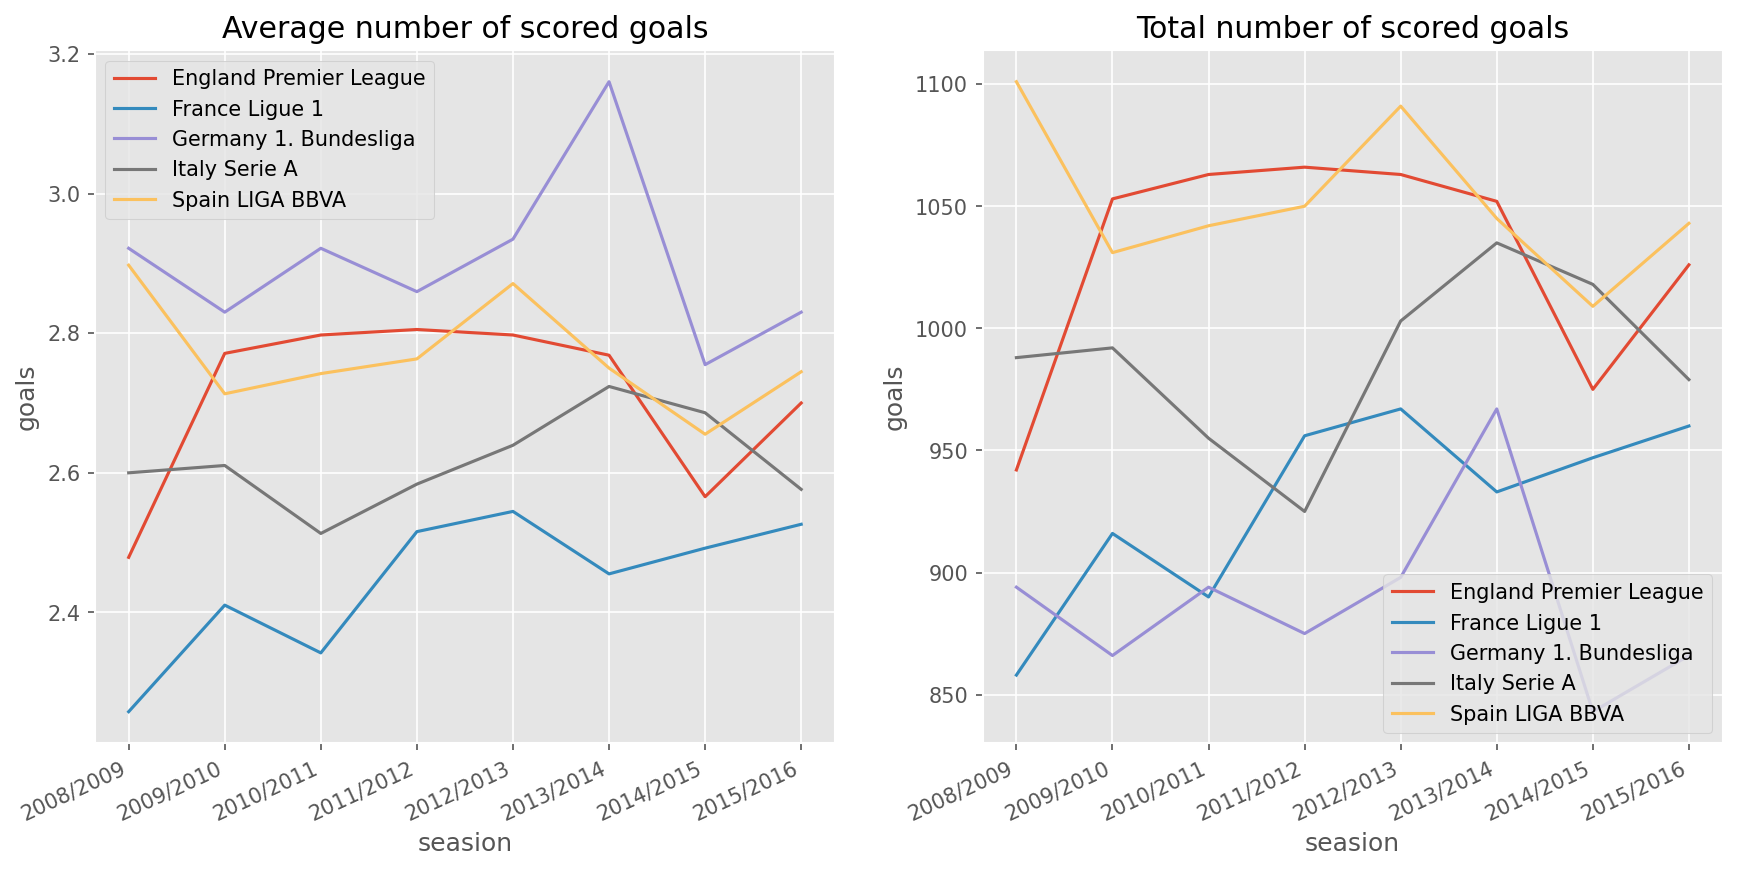

In [23]:
fig, axs = plt.subplots(1,2,figsize=(14,6),dpi=150)

axs[0].plot(seasons, en.total_goals, label=leagues[1])
axs[0].plot(seasons, fr.total_goals, label=leagues[2])
axs[0].plot(seasons, ge.total_goals, label=leagues[3])
axs[0].plot(seasons, it.total_goals, label=leagues[4])
axs[0].plot(seasons, sp.total_goals, label=leagues[9])
axs[0].set_title('Average number of scored goals')
axs[0].set_xlabel('seasion')
axs[0].set_ylabel('goals')
axs[0].set_xticks(list(axs[0].get_xticks()))
axs[0].set_xticklabels(seasons,rotation=25, horizontalalignment='right')
axs[0].legend()

axs[1].plot(seasons, en2.total_goals, label=leagues[1])
axs[1].plot(seasons, fr2.total_goals, label=leagues[2])
axs[1].plot(seasons, ge2.total_goals, label=leagues[3])
axs[1].plot(seasons, it2.total_goals, label=leagues[4])
axs[1].plot(seasons, sp2.total_goals, label=leagues[9])
axs[1].set_title('Total number of scored goals')
axs[1].set_xlabel('seasion')
axs[1].set_ylabel('goals')
axs[1].set_xticks(list(axs[1].get_xticks()))
axs[1].set_xticklabels(seasons,rotation=25, horizontalalignment='right')
axs[1].legend()

plt.show()

# this plot with seaborn
#sns.lineplot(x="season", y="total_goals", hue="league", data=match2, palette = palette)

The teams of 1. Bundesliga scored more goals per match than the teams of the other leagues. During the season 2013/2014 the Bundeslaga teams scored more than 3 goals per match. The teams of French League 1 scored the least number of goals per match with between 2.3 and 2.5.

However the total number of scored goals is in Premier League and Liga BBVA (Spain) than in the Bundesliga. This is due to the different number of teams playing in the leagues and therefore more matche take place. In Spain and in England there are playing 20 teams (-> 38 matches per team) and in Germany 18 teams (-> 34 matches per team)

## Soccer games with highest number of goals in each league and season

Grapping and listing soccer games with highest number of scored goals, soccer games with highest home team victories, and soccer games with highest away team victories

In [24]:
# new table with a sample columns for printing
match3 = match2[['season','country','league','date','team_long_name_h','team_long_name_a',
                 'home_team_goal','away_team_goal','total_goals']].copy()
match3.rename(columns={'team_long_name_h':'home_team','team_long_name_a':'away_team'},inplace=True)
#season = match3.season.unique()
#country = match3.country.unique()

In [25]:
# games with higest number of goals for every league and season
for c in ['Germany','Spain','England','Italy','France']:
    print('')
    print("{:} ({:})".format(match3.league[match3.country == c].iloc[0],c))
    print(50*"=")
    for s in seasons:
        # Spiel mit den meisten Toren
        wins = match3[(match3.season == s) & (match3.country == c)]
        game = wins[(wins.total_goals == wins.total_goals.max())]
        s0 = game.season.values[0]
        d0 = game.date.values[0]
        ht = game.home_team.values[0]
        at = game.away_team.values[0]
        hg = game.home_team_goal.values[0]
        ag = game.away_team_goal.values[0]
        print("Seasion {:10} {:10} >> {:2.0f} : {:2.0f} << {:25} : {:25}".format(s0,d0[:10],hg,ag,ht,at))


Germany 1. Bundesliga (Germany)
Seasion 2008/2009  2008-09-27 >>  5 :  4 << SV Werder Bremen          : TSG 1899 Hoffenheim      
Seasion 2009/2010  2009-12-12 >>  5 :  3 << Borussia Mönchengladbach  : Hannover 96              
Seasion 2010/2011  2010-08-29 >>  3 :  6 << Bayer 04 Leverkusen       : Borussia Mönchengladbach 
Seasion 2011/2012  2012-03-10 >>  7 :  1 << FC Bayern Munich          : TSG 1899 Hoffenheim      
Seasion 2012/2013  2013-03-30 >>  9 :  2 << FC Bayern Munich          : Hamburger SV             
Seasion 2013/2014  2013-11-09 >>  5 :  3 << Bayer 04 Leverkusen       : Hamburger SV             
Seasion 2014/2015  2015-02-14 >>  4 :  5 << Bayer 04 Leverkusen       : VfL Wolfsburg            
Seasion 2015/2016  2016-05-02 >>  6 :  2 << SV Werder Bremen          : VfB Stuttgart            

Spain LIGA BBVA (Spain)
Seasion 2008/2009  2009-03-08 >>  5 :  3 << RC Deportivo de La Coruña : Racing Santander         
Seasion 2009/2010  2010-02-21 >>  6 :  2 << Real Madrid CF  

In [26]:
# highest home team victory and highest away team victory for every league
for c in countries:
    print('')
    print("{:} ({:})".format(match3.league[match3.country == c].iloc[0],c))
    print(50*"=")
    # höchster Heimsieg
    wins = match3[(match3.country == c) & (match3.home_team_goal > match3.away_team_goal)]
    game1 = wins[(wins.home_team_goal == wins.home_team_goal.max())]
    s0 = game1.season.values[0]
    d0 = game1.date.values[0]
    ht = game1.home_team.values[0]
    at = game1.away_team.values[0]
    hg = game1.home_team_goal.values[0]
    ag = game1.away_team_goal.values[0]
    print("Seasion {:10} {:10} >> {:2.0f} : {:2.0f} << {:25} : {:25}".format(s0,d0[:10],hg,ag,ht,at))
    # höchster Auswärtssieg
    wins = match3[(match3.country == c) & (match3.home_team_goal < match3.away_team_goal)]
    game2 = wins[(wins.away_team_goal == wins.away_team_goal.max())]
    s0 = game2.season.values[0]
    d0 = game2.date.values[0]
    ht = game2.home_team.values[0]
    at = game2.away_team.values[0]
    hg = game2.home_team_goal.values[0]
    ag = game2.away_team_goal.values[0]
    print("Seasion {:10} {:10} >> {:2.0f} : {:2.0f} << {:25} : {:25}".format(s0,d0[:10],hg,ag,ht,at))


Belgium Jupiler League (Belgium)
Seasion 2008/2009  2008-10-25 >>  7 :  1 << RSC Anderlecht            : KV Mechelen              
Seasion 2012/2013  2012-12-09 >>  1 :  7 << Beerschot AC              : Club Brugge KV           

England Premier League (England)
Seasion 2009/2010  2009-11-22 >>  9 :  1 << Tottenham Hotspur         : Wigan Athletic           
Seasion 2009/2010  2009-08-15 >>  1 :  6 << Everton                   : Arsenal                  

France Ligue 1 (France)
Seasion 2010/2011  2010-12-05 >>  6 :  3 << LOSC Lille                : FC Lorient               
Seasion 2015/2016  2016-03-13 >>  0 :  9 << ES Troyes AC              : Paris Saint-Germain      

Germany 1. Bundesliga (Germany)
Seasion 2012/2013  2013-03-30 >>  9 :  2 << FC Bayern Munich          : Hamburger SV             
Seasion 2010/2011  2011-05-07 >>  1 :  8 << FC St. Pauli              : FC Bayern Munich         

Italy Serie A (Italy)
Seasion 2014/2015  2014-11-09 >>  7 :  0 << Juventus               

## Frequency of game results

In [27]:
# games ending with home-team-wins, ties, and away-team-wins 
home = match2.id[(match2.home_team_goal > match2.away_team_goal)].count()
tie = match2.id[(match2.home_team_goal == match2.away_team_goal)].count()
away = match2.id[(match2.home_team_goal < match2.away_team_goal)].count()
games = match2.shape[0]

print('home team wins: {:5.0f} - {:4.2f}% of games'.format(home, home/games*100))
print('game ends tie:  {:5.0f} - {:4.2f}% of games'.format(tie, tie/games*100))
print('away team wins: {:5.0f} - {:4.2f}% of games'.format(away, away/games*100))
print(home+tie+away,match2.shape)

home team wins: 11917 - 45.87% of games
game ends tie:   6596 - 25.39% of games
away team wins:  7466 - 28.74% of games
25979 (25979, 18)


In [28]:
# frequency of game results. How often has occured a certain result?
results = pd.pivot_table(match2, index=["away_team_goal"], values=["id"],
               columns=["home_team_goal"], aggfunc=[np.size], fill_value=0).astype('int')
results

size                                             
                  id                                             
home_team_goal    0     1     2     3    4    5   6   7  8  9  10
away_team_goal                                                   
0               1978  2643  2132  1127  538  175  66  21  5  1  1
1               1863  3014  2180  1206  478  174  56  13  3  2  0
2               1205  1659  1310   613  245   79  31   1  1  1  1
3                534   741   488   264   87   22   6   3  0  0  0
4                220   248   167    50   27    5   1   0  0  0  0
5                 66    72    44    21   10    2   0   0  0  0  0
6                 21    18    16     7    0    0   1   0  0  0  0
7                  5     4     1     0    0    0   0   0  0  0  0
8                  3     1     1     0    0    0   0   0  0  0  0
9                  1     0     0     0    0    0   0   0  0  0  0

The most games end with a tie, most often with 1:1 and 0:0. These are the 6 most ofen game results: <br>
  - 1:1
  - 1:0
  - 2:1
  - 2:0
  - 2:1
  - 0:0
  - 0:1
  
Home-teams win more often than away teams. This indicates a home-team advantage. Home-teams score more goals than away teams and therefore they win more often. Probably, this is bacause they are motivated and cheered by their fans. Home-teams play more offensive than away-teams. Also referees tend to decide slightly more for the home-teams.

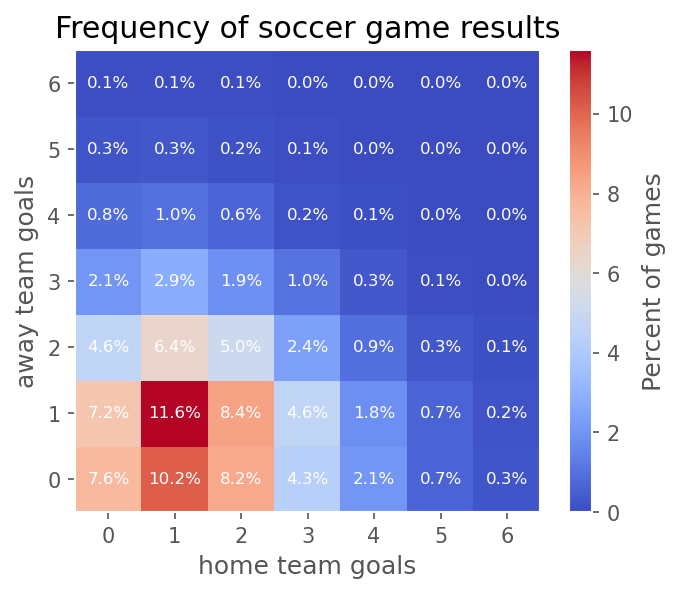

In [29]:
# probability of game results
results2 = results.to_numpy()
results2 = results2/results2.sum(axis=None)*100

# color map of game result probability
fig, axs = plt.subplots(1,1,figsize=(5,4),dpi=150)

ny, nx = results2.shape
xt = list(range(nx))
yt = list(range(ny))
f = axs.pcolormesh(xt, yt, results2, cmap='coolwarm', rasterized=True, shading='auto')
#axs.set_xticks(xt)
plt.xlabel('home team goals')
plt.ylabel('away team goals')
plt.title('Frequency of soccer game results')

cbar = plt.colorbar(f,ax=axs)
cbar.set_label('Percent of games')

# put the major ticks at the middle of each cell
axs.set_xticks(np.arange(0,results2.shape[1],1), minor=False)
axs.set_yticks(np.arange(0,results2.shape[0],1), minor=False)

# labels (overwrite the automacally generated labels)
axs.set_xticklabels(xt, minor=False)
axs.set_yticklabels(yt, minor=False)

nx,ny=np.shape(results2)
for i in np.arange(0,7):
    for j in np.arange(0,7):
        axs.text(j, i, "{:3.1f}%".format(results2[i,j]), color='white',
                horizontalalignment='center', verticalalignment='center',fontsize=8)

axs.set_xlim([-0.5,6.5])
axs.set_ylim([-0.5,6.5])

plt.show()

Mostly soccer games end with 1:1. Than follows 1:0, 2:0, and 2:1. Then 0:0 tie and then the first away team victory with 0:1. Generally home teams win more often than away teams. In rankings victories from home teams are more probable than from away team. Generally home teams shoot more goals than away teams.

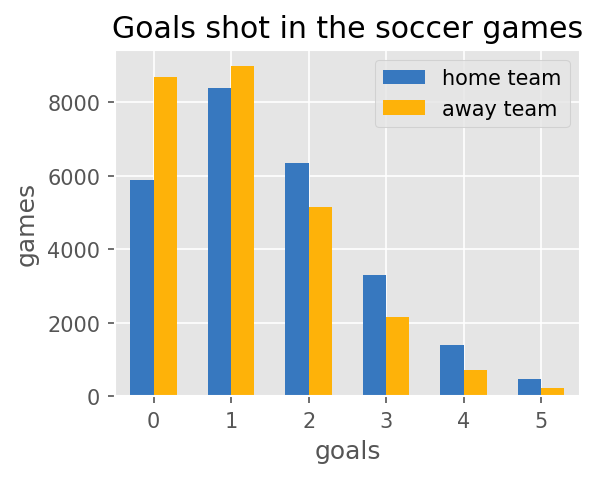

In [30]:
# games with a specific number of goals
num_homegoals = results.sum(axis=0)
num_awaygoals = results.sum(axis=1)

# barplot of the number of goals from home- and away-team
plt.matplotlib.style.use('ggplot')

fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi=150)

width = 0.3
x1 = [ i-width/2         for i in range(len(num_homegoals)) ]
x2 = [ i-width/2 + width for i in range(len(num_awaygoals)) ]
xt = [i for i in range(11)]

plt.bar(x1, num_homegoals, width, color=colors[0], label="home team")
plt.bar(x2, num_awaygoals, width, color=colors[1], label="away team")

ax.set_xticks(xt)
ax.set_xlim([-0.5,5.5])
plt.title('Goals shot in the soccer games')
plt.ylabel('games')
plt.xlabel('goals')
plt.legend(loc=1)

plt.show()

# Home teams in comparison to away teams

Overview of goals scored by home-teams and by away-teams. Are there differences between the leaghues and and does the difference change over the seasons?

In [31]:
plt.style.use('ggplot')

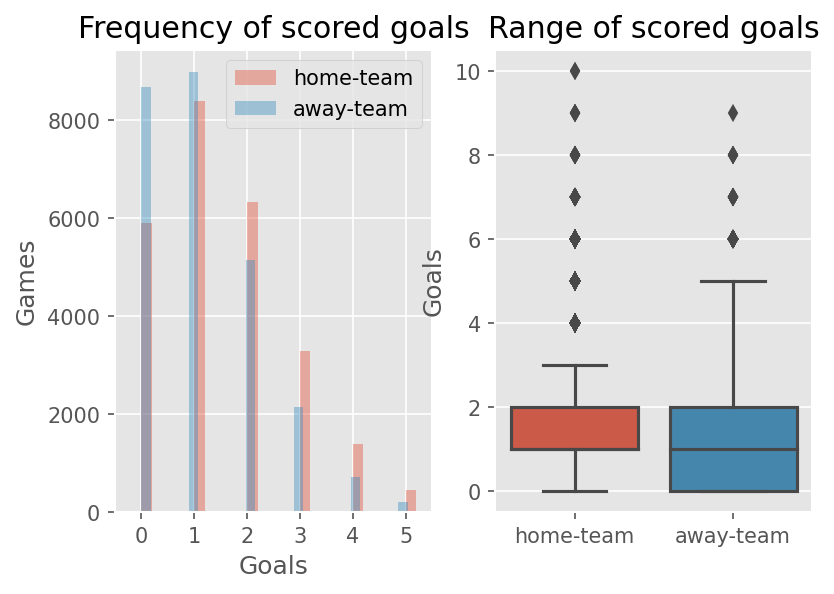

In [32]:
# Number of goals shot by home teams and by away teams
fig, axes = plt.subplots(1,2,figsize=(6,4),dpi=150)

# should be the same plot as made during the games result study above
sns.distplot(match2['home_team_goal'], kde = False, ax = axes[0], label = 'home-team')
sns.distplot(match2['away_team_goal'], kde = False, ax = axes[0], label = 'away-team')
axes[0].set_title('Frequency of scored goals')
axes[0].set_xlabel('Goals')
axes[0].set_ylabel('Games')
axes[0].set_xticks([i for i in range(11)])
axes[0].set_xlim([-0.5,5.5])
axes[0].legend()

# spread of shot goals: median, quantiles, and outliers
sns.boxplot(data=match2[['home_team_goal','away_team_goal']], ax = axes[1])
axes[1].set_title('Range of scored goals')
axes[1].set_ylabel('Goals')
axes[1].set_xticklabels(['home-team','away-team'])

plt.show()

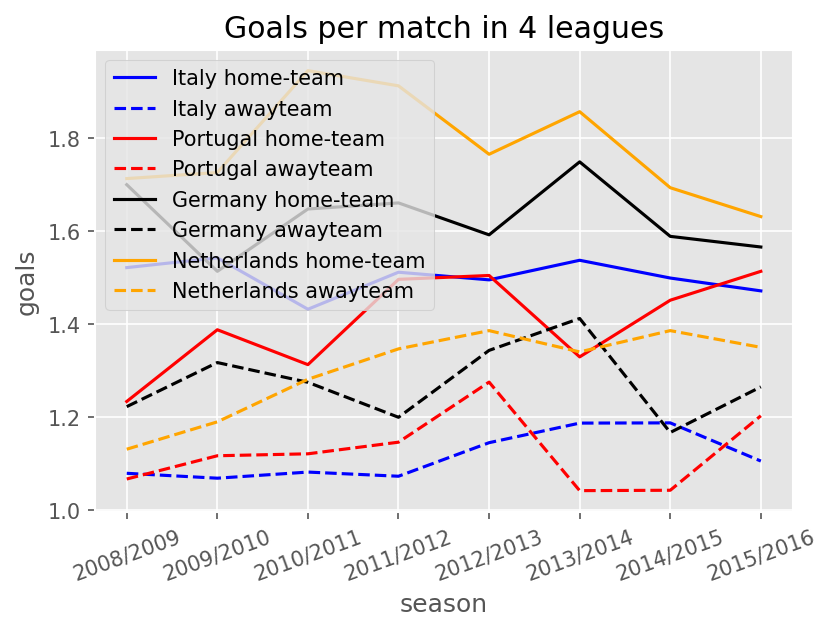

In [33]:
# home-team goals and away-team goals for 4 leagues aver 8 seasons
plt.figure(figsize=(6,4),dpi=150)
plt.title('Goals per match in 4 leagues')
plt.xlabel('season')
plt.ylabel('goals')
plt.xticks(rotation=20)
plt.plot(it.home_team_goal,'-b',label='Italy home-team')
plt.plot(it.away_team_goal,'--b',label='Italy awayteam')
plt.plot(po.home_team_goal,'-r',label='Portugal home-team')
plt.plot(po.away_team_goal,'--r',label='Portugal awayteam')
plt.plot(ge.home_team_goal,'-',color='black',label='Germany home-team')
plt.plot(ge.away_team_goal,'--',color='black',label='Germany awayteam')
plt.plot(nl.home_team_goal,ls='-',color='orange',label='Netherlands home-team')
plt.plot(nl.away_team_goal,ls='--',color='orange',label='Netherlands awayteam')
plt.legend(loc='upper left')
plt.show()

## Do home-teams score more goals?

The question is answered with a t-test

H0 hypothesis: The average number of home-team scores is not different from away-team scores <br>
H1 hypothesis: The average number of home-team scores is different from away-team scores

In [34]:
# average number of shot goals
home_mean = np.mean(match2.home_team_goal)
away_mean = np.mean(match2.away_team_goal)

print("average number of goals by home teams {:1.2f} and away teams {:1.2f}".format(home_mean,away_mean))
print("difference {:4.2f}%".format((home_mean-away_mean)/away_mean*100))

ttest(match2.home_team_goal, match2.away_team_goal, 0.05)

average number of goals by home teams 1.54 and away teams 1.16
difference 33.05%
t-Test
------------------------------------------------------------
t = 35.779	p = 0.000	df = 51956.000	r = 0.155
------------------------------------------------------------
Different distribution (reject H0 -> H1 is accepted)


In average home-teams score more goals then away-teams (1.54:1.16). This is a large difference. Home-teams score 33% more goals than away teams. The t-test shows that the means are significantly different, which indicates a clear home-team advantage. Therefore home-teams win more games than away-teams do.  <br>

## Is this advantage different throughout the leagues? Does it change over time?

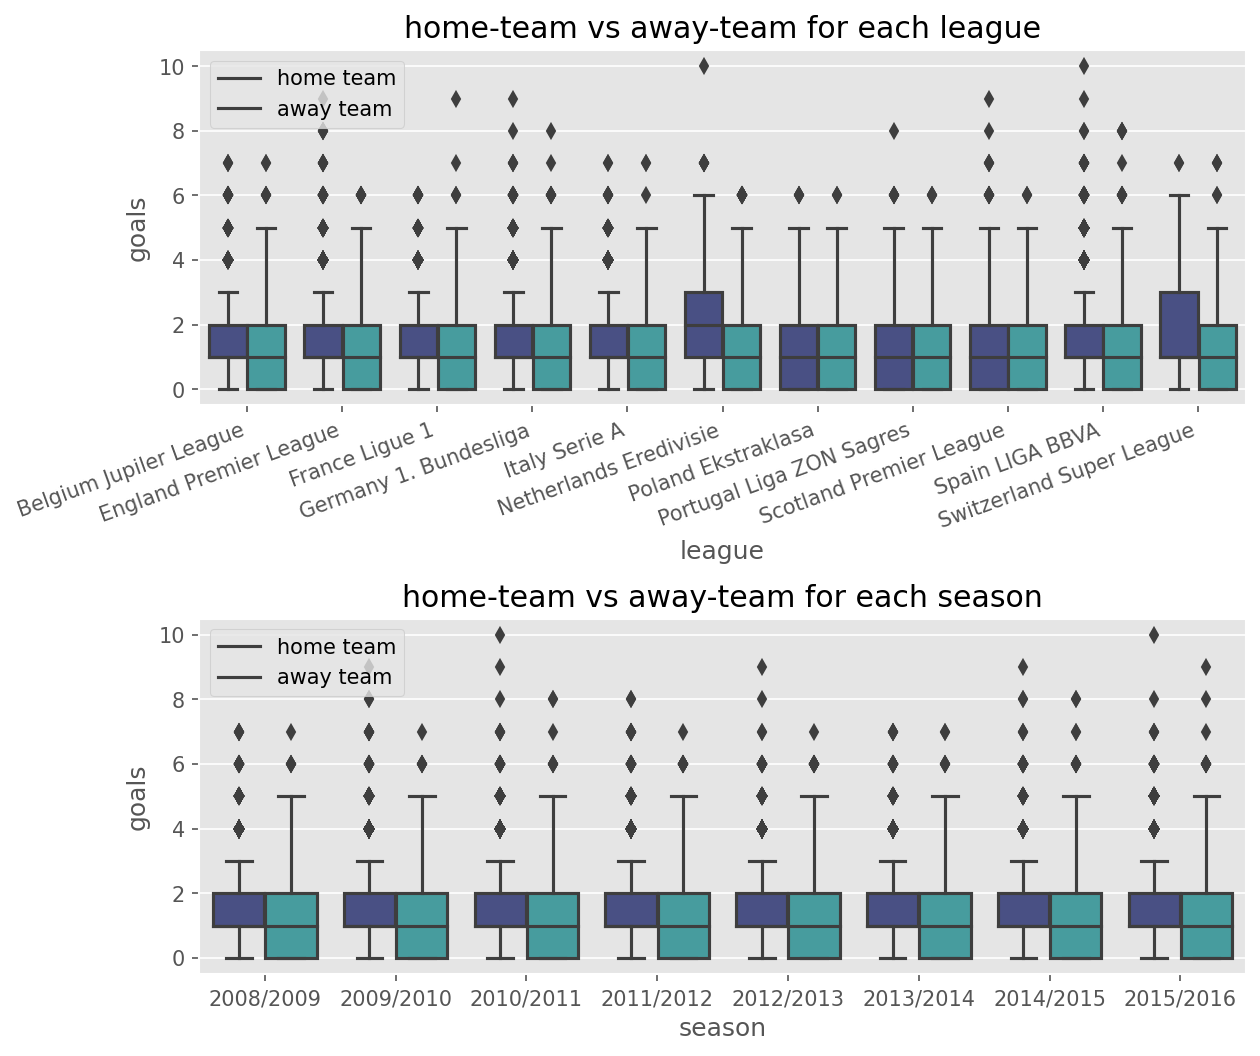

In [35]:
# puting home-team goals and away-team goals into one column
match3 = pd.melt(match2,id_vars='league',value_vars=['home_team_goal','away_team_goal'])
match4 = pd.melt(match2,id_vars='season',value_vars=['home_team_goal','away_team_goal'])

# boxplots
fig, axs = plt.subplots(2,1,figsize=(9,8),dpi=150)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)

# home team goals vs away team goal in each league
sns.boxplot(x='league', y='value', hue='variable', width=0.8, data=match3, palette="mako", ax=axs[0])
axs[0].set_title('home-team vs away-team for each league')
axs[0].set_ylabel('goals')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=20, horizontalalignment='right')
axs[0].legend(labels=['home team','away team'])

# home team goals vs away team goal for each season
sns.boxplot(x='season', y='value', hue='variable', width=0.8, data=match4, palette="mako", ax=axs[1])
axs[1].set_title('home-team vs away-team for each season')
axs[1].set_ylabel('goals')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0, horizontalalignment='center')
axs[1].legend(labels=['home team','away team'])

plt.show()

## Did the home-team advantage change over time?

The question will be answered with a t-test of the the home-team advantage in two seasons

H0 hypothesis: the difference between home-team and away-team goals has not changed from season 2008/2009 to season 2015/2016 <br>
H1 hypothesis: the difference between home-team and away-team goals has changed from season 2008/2009 to season 2015/2016

In [36]:
# difference between home-team goals and away-team goals in seasons 2008/2009 and 2015/2016
diff_2008_09 = match2[match2.season=='2008/2009'].home_team_goal - match2[match2.season=='2008/2009'].away_team_goal
diff_2015_16 = match2[match2.season=='2015/2016'].home_team_goal - match2[match2.season=='2015/2016'].away_team_goal

# small checking of grouping results above
print('season 2008/2009: ', diff_2008_09.mean(), 1.505412-1.101924)
print('season 2015/2016: ', diff_2015_16.mean(), 1.543897-1.210764)

# t-test of the difference in two seasons 
ttest(diff_2008_09, diff_2015_16, 0.05)

season 2008/2009:  0.40348767288033677 0.40348800000000007
season 2015/2016:  0.33313289236319904 0.3331330000000001
t-Test
------------------------------------------------------------
t = 1.621	p = 0.105	df = 6650.000	r = 0.020
------------------------------------------------------------
Same distribution (fail to reject H0 -> H0 is accepted)


From the t-test follows that the home-team advantages has not changed from 2008/2009 to 2015/2016

## Is the difference between Netherlands and Germany significant?

t-test of the the home-team advantage in Germany and Netherlands 

H0 hypothesis: the home-team advantage in Netherlands is not different from the home-team advantage in Germany <br>
H1 hypothesis: the home-team advantage in Netherlands is different from the home-team advantage in Germany

In [37]:
# difference between home-team goals and away-team goals in seasons 2008/2009 and 2015/2016
diff_netherlands = match2[match2.country=='Netherlands'].home_team_goal - match2[match2.country=='Netherlands'].away_team_goal
diff_germany = match2[match2.country=='Germany'].home_team_goal - match2[match2.country=='Germany'].away_team_goal

# t-test of the difference in Netherlands and Germany 
ttest(diff_netherlands, diff_germany, 0.05)

t-Test
------------------------------------------------------------
t = 2.286	p = 0.022	df = 4894.000	r = 0.033
------------------------------------------------------------
Different distribution (reject H0 -> H1 is accepted)


the difference between home team goals and away team goals remains over all seasons and does not change significantelly. But there are home-team advantage differs between some leagues on signifcance level of 0.05. Following the statistic properties median, quantiles, and outliers the home-home advantage can be set in three categories. 
 - No difference: The Polish, Scotish, and the Portuguese legues do not show a home-team advantage. 
 - Medium difference: In most legues 75% of games end with 1-2 home-teams goals and with 0-2 away-team goals
 - Large difference: In Suisse and in the Netherlands the diference is larger because home teams shoot more goals

The away team goals range between 1.1 and 1.4, while the home-team goals range between 1.9 and 1.2. The Netherlands show a large home-team advantage. The Dutch home-teams score more goals per games than teams in Germany, Italy, and Portugal. The Italian teams score less goals, this is similar to Portugal. Probably this is due to their defensive tactics. But in Italy the difference between home-teams and away teams is larger than in Portugal 

# Performance of Hamburger SV in comparison to Bayern Munich

How played Hamburger SV over the seasons? How many goals and points did this team make?

In [38]:
# selection of matches in Germany
germany = match2[(match2.country == 'Germany')].copy()

# Teams in the database: These teams have been in the 1. Bundesliga
print(germany.team_long_name_h.unique())

# number of goals and points for every team and season (home and away)
home_table = germany.groupby(['team_long_name_h','season']).sum()
away_table = germany.groupby(['team_long_name_a','season']).sum()

['FC Bayern Munich' 'Bayer 04 Leverkusen' 'FC Schalke 04' 'VfL Wolfsburg'
 'Eintracht Frankfurt' 'DSC Arminia Bielefeld' 'FC Energie Cottbus'
 'Borussia Mönchengladbach' 'Karlsruher SC' 'Hamburger SV'
 'SV Werder Bremen' 'Hertha BSC Berlin' '1. FC Köln' 'VfL Bochum'
 'Borussia Dortmund' 'VfB Stuttgart' 'Hannover 96' 'TSG 1899 Hoffenheim'
 'SC Freiburg' '1. FC Nürnberg' '1. FSV Mainz 05' '1. FC Kaiserslautern'
 'FC St. Pauli' 'FC Augsburg' 'SpVgg Greuther Fürth' 'Fortuna Düsseldorf'
 'Eintracht Braunschweig' 'SC Paderborn 07' 'SV Darmstadt 98'
 'FC Ingolstadt 04']


In [39]:
# How many seasons did the German team play in the 1. Bundesliga
nseasons = pd.pivot_table(germany, index=["team_long_name_h"], values=["season"], aggfunc=[np.size], fill_value=0)
# 17 matches at home per season
nseasons = nseasons/17
nseasons = nseasons.astype('int')
nseasons.rename(columns={'season':'n_seasons'},inplace=True)
print(nseasons)

print('number of teams',len(nseasons))
print('median played seasons',nseasons.iloc[:,0].median())

                              size
                         n_seasons
team_long_name_h                  
1. FC Kaiserslautern             2
1. FC Köln                       6
1. FC Nürnberg                   5
1. FSV Mainz 05                  7
Bayer 04 Leverkusen              8
Borussia Dortmund                8
Borussia Mönchengladbach         8
DSC Arminia Bielefeld            1
Eintracht Braunschweig           1
Eintracht Frankfurt              7
FC Augsburg                      5
FC Bayern Munich                 8
FC Energie Cottbus               1
FC Ingolstadt 04                 1
FC Schalke 04                    8
FC St. Pauli                     1
Fortuna Düsseldorf               1
Hamburger SV                     8
Hannover 96                      8
Hertha BSC Berlin                6
Karlsruher SC                    1
SC Freiburg                      6
SC Paderborn 07                  1
SV Darmstadt 98                  1
SV Werder Bremen                 8
SpVgg Greuther Fürth

Betwwen 2008 and 2016 Hamburger SV played all 8 seasons in the 1. Bundesliga. In total 30 teams have played there during this time. 16 teams are playing in one season. The median is at 6 played seasons. 12 teams have played only for one or two seasons and descended afterwards.  

## Goals and Points

The next step includes the analysis of scored goals, points, and goals got by the German teams Hamburger SV and FC Bayern Munich between 2008 and 2016.

In [40]:
# performance
perf = home_table[['home_team_goal','home_team_point']].copy()
perf.insert(2,'away_team_goal',away_table.away_team_goal)
perf.insert(3,'away_team_point',away_table.away_team_point)

# scored goals
perf['total_goal'] = perf.home_team_goal + perf.away_team_goal

# goal against
perf['goal_against'] = home_table.away_team_goal + away_table.home_team_goal

# number of points
perf['total_point'] = perf.home_team_point + perf.away_team_point

In [41]:
hsv = perf.loc['Hamburger SV']
fcb = perf.loc['FC Bayern Munich']

# Hamburger SV in the following seasons 2016/2017 and 2017/2018
# 33:61 - 38
# 29:53 - 31
hsv = hsv.append(pd.Series(data=[np.nan, np.nan, np.nan, np.nan, 33, 61, 38],
                                          index=perf.columns).rename('2016/2017') )
hsv = hsv.append(pd.Series(data=[np.nan, np.nan, np.nan, np.nan, 29, 53, 31],
                                           index=perf.columns).rename('2017/2018') )

# Fc Bayern Munich in the following seasons 2016/2017 and 2017/2018
# 89:22 - 82
# 92:28 - 84
fcb = fcb.append(pd.Series(data=[np.nan, np.nan, np.nan, np.nan, 89, 22, 82],
                                              index=perf.columns).rename('2016/2017') )
fcb = fcb.append(pd.Series(data=[np.nan, np.nan, np.nan, np.nan, 92, 28, 84],
                                              index=perf.columns).rename('2017/2018') )

# placing of Hamburger SV and Bayern Munich
hsv['placing'] = [5, 7, 8, 15, 7, 16, 16, 10, 14, 17]
fcb['placing'] = [2, 1, 3,  2, 1,  1,  1,  1,  1,  1]

Hamburger SV has performed well in the first seasons, but became weaker in the seasons afterwards. Two times the team played against descending in the relegation (2013/2014 and 2014/2015). 

Placings are visible on www.transfermarkt.de 

In [42]:
fcb

,home_team_goal,home_team_point,away_team_goal,away_team_point,total_goal,goal_against,total_point,placing
season,,,,,,,,
2008/2009,45.0,38.0,26.0,29.0,71.0,42.0,67.0,2
2009/2010,39.0,40.0,33.0,30.0,72.0,31.0,70.0,1
2010/2011,48.0,41.0,33.0,24.0,81.0,40.0,65.0,3
2011/2012,49.0,43.0,28.0,30.0,77.0,22.0,73.0,2
2012/2013,56.0,44.0,42.0,47.0,98.0,18.0,91.0,1
2013/2014,48.0,46.0,46.0,44.0,94.0,23.0,90.0,1
2014/2015,46.0,43.0,34.0,36.0,80.0,18.0,79.0,1
2015/2016,51.0,46.0,29.0,42.0,80.0,17.0,88.0,1
2016/2017,NaN,NaN,NaN,NaN,89.0,22.0,82.0,1


In [43]:
plt.style.use('seaborn-darkgrid')

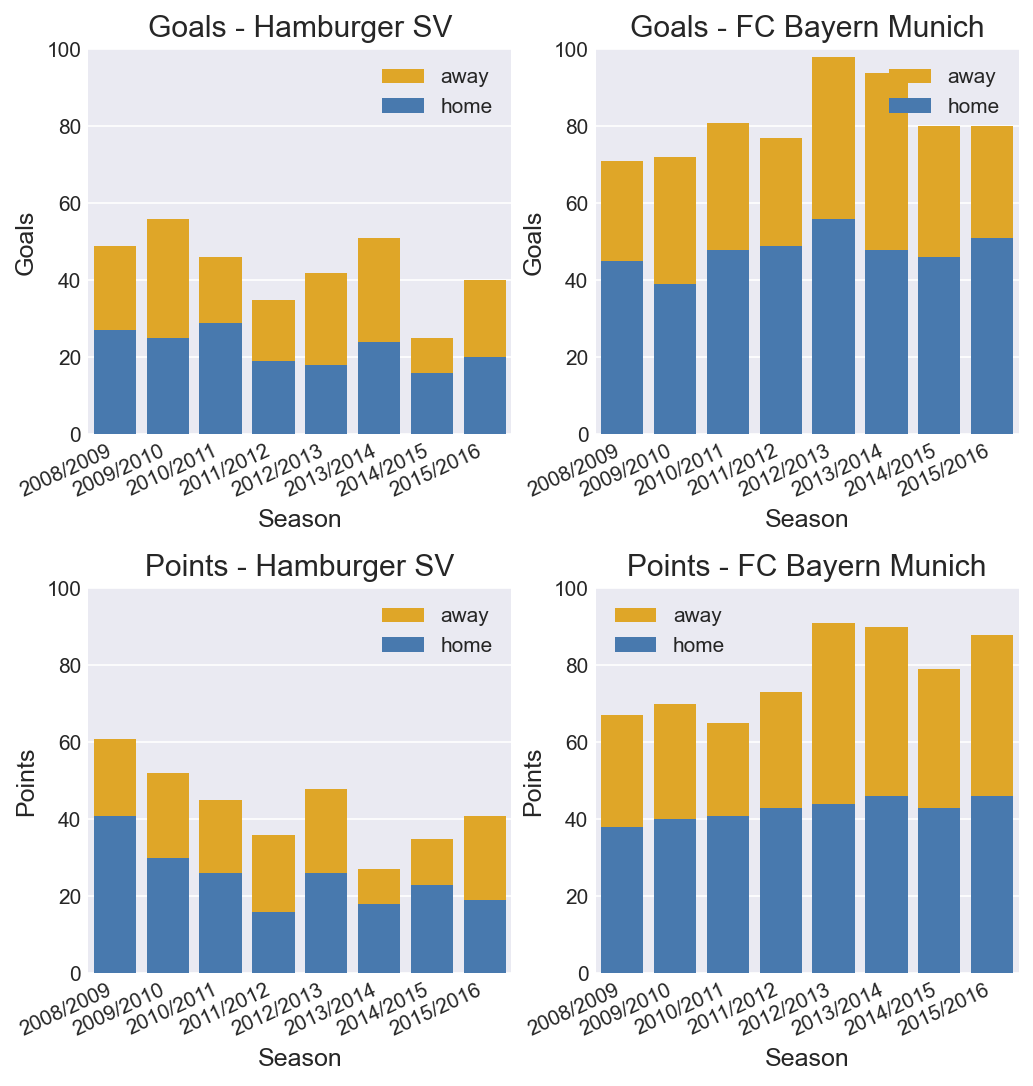

In [44]:
# comparing points and goals of Hamburger SV and FC Bayern Munich with a barplot
fig, axs = plt.subplots(2,2,figsize=(8,8),dpi=150)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

tm1 = 'Hamburger SV'
tm2 = 'FC Bayern Munich'

# Goals of Hamburger SV
sns.barplot(x=perf.loc[tm1].index, y=perf.loc[tm1].total_goal, color=colors[1], label='away', ax=axs[0,0])
sns.barplot(x=perf.loc[tm1].index, y=perf.loc[tm1].home_team_goal, color=colors[0], label='home', ax=axs[0,0])
axs[0,0].set_title('Goals - Hamburger SV')
axs[0,0].set_xlabel('Season')
axs[0,0].set_ylabel('Goals')
axs[0,0].set_ylim([0,100])
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=25, horizontalalignment='right')
axs[0,0].legend()

# Points of Hamburger SV
sns.barplot(x=perf.loc[tm1].index, y=perf.loc[tm1].total_point, color=colors[1], label='away', ax=axs[1,0])
sns.barplot(x=perf.loc[tm1].index, y=perf.loc[tm1].home_team_point, color=colors[0], label='home', ax=axs[1,0])
axs[1,0].set_title('Points - Hamburger SV')
axs[1,0].set_xlabel('Season')
axs[1,0].set_ylabel('Points')
axs[1,0].set_ylim([0,100])
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=25, horizontalalignment='right')
axs[1,0].legend()

# Goals of FC Bayern Munich
sns.barplot(x=perf.loc[tm2].index, y=perf.loc[tm2].total_goal, color=colors[1], label='away', ax=axs[0,1])
sns.barplot(x=perf.loc[tm2].index, y=perf.loc[tm2].home_team_goal, color=colors[0], label='home', ax=axs[0,1])
axs[0,1].set_title('Goals - FC Bayern Munich')
axs[0,1].set_xlabel('Season')
axs[0,1].set_ylabel('Goals')
axs[0,1].set_ylim([0,100])
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=25, horizontalalignment='right')
axs[0,1].legend()

# Points of FC Bayern Munich
sns.barplot(x=perf.loc[tm2].index, y=perf.loc[tm2].total_point, color=colors[1], label='away', ax=axs[1,1])
sns.barplot(x=perf.loc[tm2].index, y=perf.loc[tm2].home_team_point, color=colors[0], label='home', ax=axs[1,1])
axs[1,1].set_title('Points - FC Bayern Munich')
axs[1,1].set_xlabel('Season')
axs[1,1].set_ylabel('Points')
axs[1,1].set_ylim([0,100])
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=25, horizontalalignment='right')
axs[1,1].legend()

plt.show()

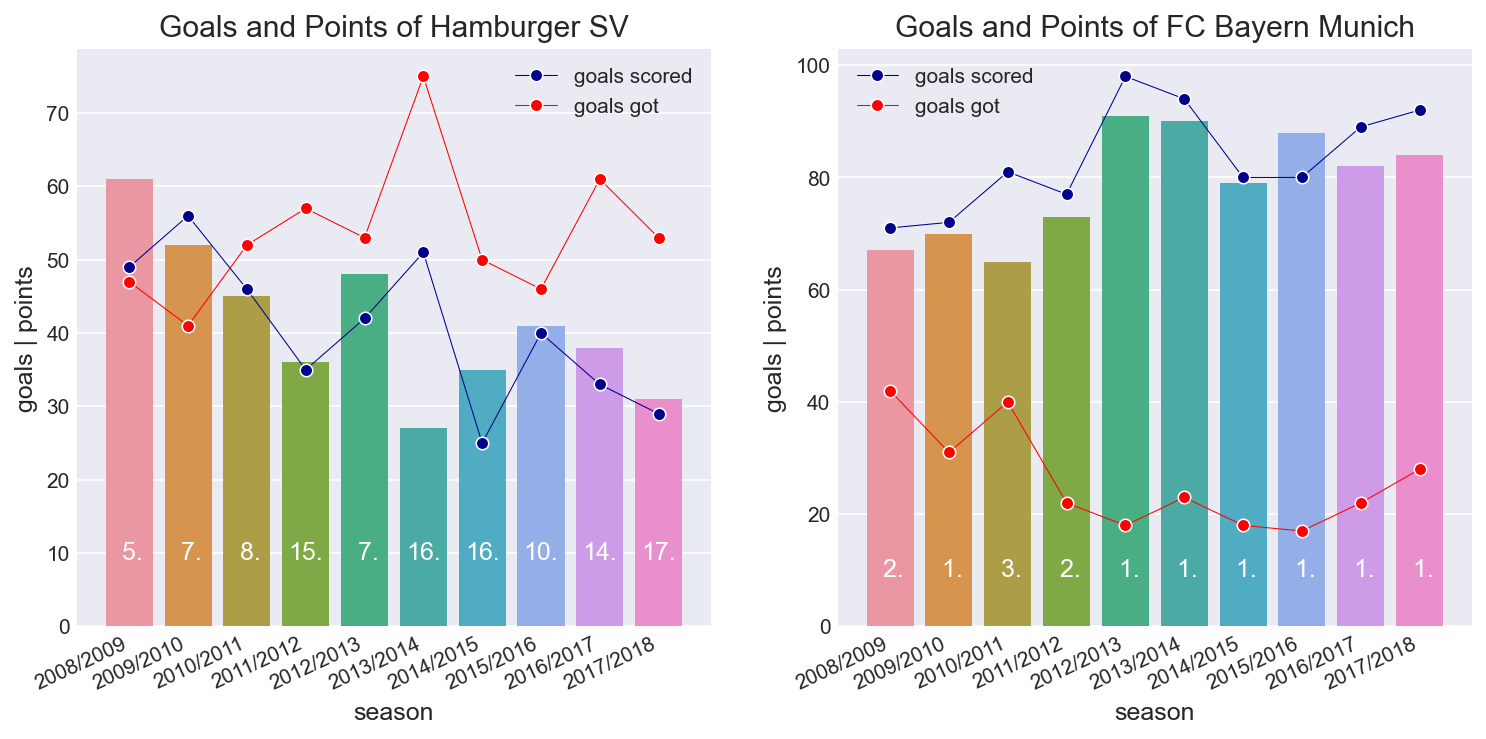

In [45]:
# points, goals scoared, goals got and placings from Hamburger SV and FC Bayern Munich
fig, axs = plt.subplots(1,2,figsize=(12,5),dpi=150)

# Hamburger SV
sns.barplot(x=hsv.index, y=hsv.total_point, ax=axs[0])
sns.lineplot(x=hsv.index, y=hsv.total_goal, color='darkblue', 
             ls='-', lw=0.5, marker='o', ax=axs[0], label='goals scored')
sns.lineplot(x=hsv.index, y=hsv.goal_against, color='red', 
             ls='-', lw=0.5, marker='o', ax=axs[0], label='goals got')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=25, horizontalalignment='right')
axs[0].legend()
axs[0].set_ylabel('goals | points')
axs[0].set_xlabel('season')
axs[0].set_title('Goals and Points of Hamburger SV')

for i in np.arange(0,10):
    axs[0].text(i, 10, "{:2.0f}.".format(hsv.placing[i]), color='white',
                horizontalalignment='center', verticalalignment='center', fontsize=12)

# FC Bayern Munich
sns.barplot(x=fcb.index, y=fcb.total_point, ax=axs[1])
sns.lineplot(x=fcb.index, y=fcb.total_goal, color='darkblue', 
             ls='-', lw=0.5, marker='o', ax=axs[1], label='goals scored')
sns.lineplot(x=fcb.index, y=fcb.goal_against, color='red', 
             ls='-', lw=0.5, marker='o', ax=axs[1], label='goals got')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=25, horizontalalignment='right')
axs[1].legend()
axs[1].set_ylabel('goals | points')
axs[1].set_xlabel('season')
axs[1].set_title('Goals and Points of FC Bayern Munich')

for i in np.arange(0,10):
    axs[1].text(i, 10, "{:2.0f}.".format(fcb.placing[i]), color='white',
                horizontalalignment='center', verticalalignment='center', fontsize=12)

plt.show()

In [46]:
# Pearson correlation between goals and points at the end of the sasons
h_cor = st.pearsonr(perf.home_team_goal, perf.home_team_point)
a_cor = st.pearsonr(perf.away_team_goal, perf.away_team_point)
t_cor = st.pearsonr(perf.total_goal,perf.total_point)

print('home - correlation {:3.2f}, p-value {:4.3f}'.format(h_cor[0],h_cor[1]))
print('away - correlation {:3.2f}, p-value {:4.3f}'.format(a_cor[0],a_cor[1]))
print('all  - correlation {:3.2f}, p-value {:4.3f}'.format(t_cor[0],t_cor[1]))

home - correlation 0.86, p-value 0.000
away - correlation 0.77, p-value 0.000
all  - correlation 0.87, p-value 0.000


Both teams score more goals at home than away. Therefore they also win more points away than at home. But they developed differently. Bayern Munich won the championship 7 times between 2008 and 2017. Hamburger SV played in relegation against descending two times and finally descended in season 2017/2018. Bayern Munich scores many more goals than Hamburg. This is already visible in the season 2008/2009, when they had simiilar number of points. Bayern Munich scores between 65 and 90 goals and improves over time. But for Hamburger SV, there is a clear negative trend visible to less goals and therefore less points. Hamburger SV scored between 20 and 55 goals and only won 28 points in season 2013/2014. In the correlation study above, it is shown that the correlation is very strong. Goals and points correlate to 87%. Furthermore Hamburger SV has got more goals than they scored from season 2010/2011 onwards. The larger the negative goal balance the worser is the placing at the end of the sseason. The team would have needed better players to shoot more goals and to defend attacks of the other temas. But this will be discussed in the next topic. 

However, Hamburger SV will return into the 1. Bundesliga latest in year 2021. 